<a href="https://colab.research.google.com/github/bartleyn/practice/blob/master/Scaling_TablePipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Running Tabular QA Transformer Pipelines

This is a notebook tutorial for how to run the Tabular Question Answering pipeline module in the Huggingface Transformers python library. 

There are roughly three types of tabular QA models available pre-trained:


1.  **Conversational** (e.g., SQA). This is useful for use-cases where you want to issue follow-up queries in a conversational manner.
2.  **Weakly supervised** for aggregation (e.g., WTQ). This is useful if you want the model to have learned the appropriate aggregation label (SUM/COUNT/AVERAGE/NONE) without ground-truth labels in the training data.
3.  **Strongly supervised** for aggregation (e.g., WikiSQL-supervised). This is useful if you want the model to have been trained with ground-truth aggregation operators alongside the training data.

## 1. Installation

In [2]:
!pip install transformers
!pip install sentencepiece
!pip install pandas
!pip install torch-scatter

     |████████████████████████████████| 2.3MB 14.9MB/s 
     |████████████████████████████████| 901kB 39.2MB/s 
     |████████████████████████████████| 3.3MB 40.4MB/s 
     |████████████████████████████████| 1.2MB 12.5MB/s 
  Created wheel for torch-scatter: filename=torch_scatter-2.0.7-cp37-cp37m-linux_x86_64.whl size=292376 sha256=7deb7014dafa0765d46fa28a5b4d17d2782e85961fee0fb865750388c95413ae
  Stored in directory: /root/.cache/pip/wheels/d4/47/a3/b454bae87fa5c1631826bc9b15285622675eac6baf4096b484
Successfully built torch-scatter


## 2. Imports

In [3]:
from transformers import AutoTokenizer, pipeline, AutoModelForTableQuestionAnswering
import pandas as pd

## 3. Loading Tokenizer & Model

If you want to make use of the different pre-trained models on huggingface, check out one of the various models [here](https://huggingface.co/models?filter=table-question-answering). When you go to an individual model card, click on "Use in Transformers":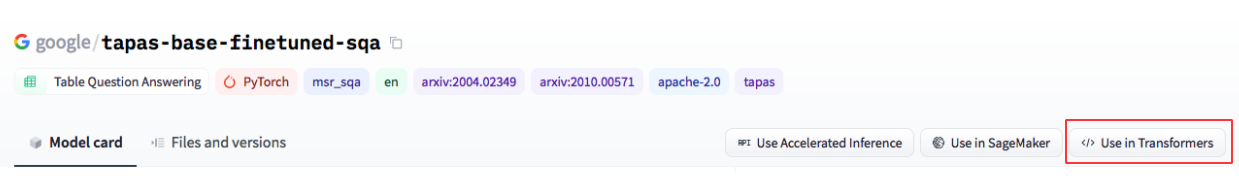

You will see example code you can use to load the model's tokenizer & model, and information about cloning it from the repo directly if you want to:

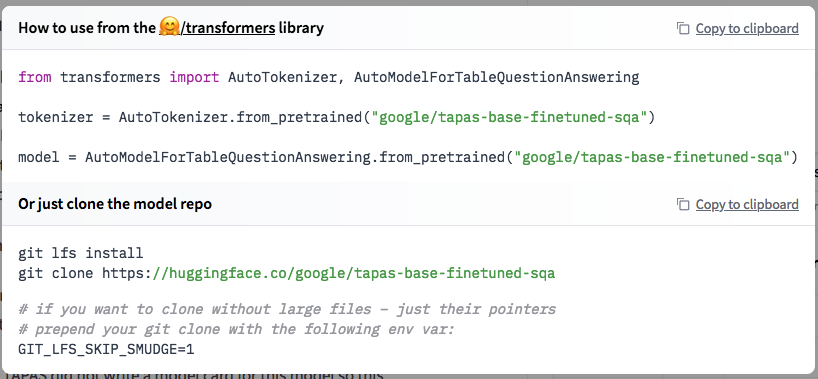

In [4]:
#tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-sqa")
tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")

In [5]:
#model = AutoModelForTableQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")
model = AutoModelForTableQuestionAnswering.from_pretrained("google/tapas-base-finetuned-wtq")

## 4. Creating Pipeline for QA

In [6]:
nlp = pipeline('table-question-answering', 
               model=model,
               tokenizer=tokenizer,
               )

## 5. Using Pre-trained Pipeline on data

You can specify your input tabular data as either a ```dict``` or a ```pd.DataFrame```.

In [9]:
table_data_movies = pd.DataFrame.from_dict({
    "actors": ["brad pitt", "leonardo di caprio", "george clooney"],
    "age": ["56", "45", "59"],
    "number of movies": ["87", "53", "69"],
    "date of birth": ["7 february 1967", "10 june 1996", "28 november 1967"],
})

table_data_grades = {
    "student": ["nathan", "alex", "lauren", "adrienne"],
    "grade": ["83", "88", "93", "87"],
    "final exam score": ["90", "91", "94", "96"],
}

You can specify queries as either:
*  a ```str``` 
*  or a ```List(str)```



In [21]:
query_movies = "How many movies was Leonardo Di Caprio in?"
query_movies = ["When was Brad Pitt born?", "How old is George Clooney?"]

query_grades = "What was Nathan's final exam score?"
query_avg = "What was the average final exam score?"

Finally, you can issue those queries on your tabular data in a variety of different formats:


*   ```pipeline(table, query)```
*   ```pipeline(table, [query])```
*   ```pipeline(table=table, query=query)```
*   ```pipeline(table=table, query=[query])```
*   ```pipeline({'table':table, 'query':query})```
*   ```pipeline({'table':table, 'query':[query]})```
*   ```pipeline([{'table':table, 'query':query}, {'table': table, 'query', query}])```





In [23]:
nlp(table=table_data_movies, query=query_movies)

[{'aggregator': 'NONE',
  'answer': '7 february 1967',
  'cells': ['7 february 1967'],
  'coordinates': [(0, 3)]},
 {'aggregator': 'AVERAGE',
  'answer': 'AVERAGE > 59',
  'cells': ['59'],
  'coordinates': [(2, 1)]}]

In [ ]:
nlp([{"table": table_data_movies, "query": query_movies}, 
    {"table": table_data_grades, "query": query_grades}])

[[{'answer': '7 february 1967',
   'cells': ['7 february 1967'],
   'coordinates': [(0, 3)]},
  {'answer': '59', 'cells': ['59'], 'coordinates': [(2, 1)]}],
 {'answer': '90', 'cells': ['90'], 'coordinates': [(0, 2)]}]

In [ ]:
nlp(table_data_grades, query_avg)

{'aggregator': 'AVERAGE',
 'answer': 'AVERAGE > 90, 91, 94, 96',
 'cells': ['90', '91', '94', '96'],
 'coordinates': [(0, 2), (1, 2), (2, 2), (3, 2)]}

Each result is a ```dict``` with the following keys:

*   **answer** - a ```str```. If an aggregator is available, will be prefaced by ```AGGREGATOR >```
*   **coordinates** - a ```List(Tuple(int,int))``` containing the coordinates of the answer (example index, field index)
*   **cells** - a ```List(str)``` containing the answer cell values
*   **aggregator** - a ```str``` if the model uses an aggregator

## 6. Aggregator

For models with an aggregation head (e.g., TAPAS pre-trained on WTQ), you may access the kind of aggregation the model predicts for your query. For example, if your query is "What is the average number of movies for each actor?" You may get the following result: 

```AVERAGE > "87", "53", "69"```


Below we run the above cells but use the ```"google/tapas-base-finetuned-wtq"``` model and tokenizer.

In [ ]:

'''Code adapted from https://huggingface.co/transformers/model_doc/tapas.html#usage-inference
'''

inputs = tokenizer(table=pd.DataFrame(table_data_grades), queries=query_avg, 
                   padding='max_length', return_tensors="pt")
outputs = model(**inputs)
#print(outputs)
predicted_answer_coordinates, predicted_aggregation_indices = tokenizer.convert_logits_to_predictions(
         inputs,
         outputs.logits.detach(),
         outputs.logits_aggregation.detach()
 )

# let's print out the results:
id2aggregation = {0: "NONE", 1: "SUM", 2: "AVERAGE", 3:"COUNT"}
aggregation_predictions_string = [id2aggregation[x] for x in predicted_aggregation_indices]

answers = []
for coordinates in predicted_answer_coordinates:
   if len(coordinates) == 1:
     # only a single cell:
     answers.append(table.iat[coordinates[0]])
   else:
     # multiple cells
     cell_values = []
     for coordinate in coordinates:
        cell_values.append(pd.DataFrame(table_data_grades).iat[coordinate])
     answers.append(", ".join(cell_values))

display(table_data_grades)
print("")
for query, answer, predicted_agg in zip([query_avg], answers, aggregation_predictions_string):
  print(query)
  if predicted_agg == "NONE":
    print("Predicted answer: " + answer)
  else:
    print("Predicted answer: " + predicted_agg + " > " + answer)

{'final exam score': ['90', '91', '94', '96'],
 'grade': ['83', '88', '93', '87'],
 'student': ['nathan', 'alex', 'lauren', 'adrienne']}


What was the average final exam score?
Predicted answer: AVERAGE > 90, 91, 94, 96


## 7. Scaling tests

In [7]:
!wget https://www.bls.gov/iif/oshwc/osh/os/summ1_00_2019.xlsx

--2021-06-09 16:54:14--  https://www.bls.gov/iif/oshwc/osh/os/summ1_00_2019.xlsx
Resolving www.bls.gov (www.bls.gov)... 88.221.11.73, 2a02:26f0:b200:386::18b9, 2a02:26f0:b200:3b0::18b9
Connecting to www.bls.gov (www.bls.gov)|88.221.11.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82128 (80K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘summ1_00_2019.xlsx’

summ1_00_2019.xlsx  100%[===================>]  80.20K  --.-KB/s    in 0.008s  

2021-06-09 16:54:14 (10.4 MB/s) - ‘summ1_00_2019.xlsx’ saved [82128/82128]



In [18]:
pd.read_excel('summ1_00_2019.xlsx', header=[2,3])

Industry(2)  ... Other recordable cases
                                     Unnamed: 0_level_1  ...     Unnamed: 7_level_1
0     All industries including private, state and lo...  ...                    NaN
1                                   Private industry(5)  ...                    NaN
2                                    Goods-producing(5)  ...                    NaN
3                    Natural resources and mining(5)(6)  ...                    NaN
4         Agriculture, forestry, fishing and hunting(5)  ...                    NaN
...                                                 ...  ...                    ...
1082  (9) Data for mining operators in this industry...  ...                    NaN
1083  (10) Data for employers in rail transportation...  ...                    NaN
1084                          (11) Rate rounded to zero  ...                    NaN
1085  Note: Because of rounding, components may not ...  ...                    NaN
1086  Source: Bureau of Labor Statistics, U.S. Depar...  ...                    NaN

[1087 rows x 8 columns]

In [10]:
input_df = pd.read_excel('summ1_00_2019.xlsx', header=[2,3]).drop([1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086]).fillna("-1").astype('string')

In [66]:
input_df.set_index(keys=input_df.columns[0], inplace=True)

In [11]:
input_df.columns = [' '.join(col).strip() for col in input_df.columns.values]

In [12]:
input_df.shape[0]

1072

In [13]:
inputs = tokenizer(table=input_df.iloc[:64,:], queries="What is the cases with days away from work for metal ore mining?", padding='max_length', return_tensors="pt", max_row_id=64)

ValueError: ignored

In [28]:
tb = input_df.iloc[:64,:].copy()
for row_index, row in tb.iterrows():
  for col_index, cell in enumerate(row):
      tb.iloc[row_index, col_index] = ["hi", "hi"]

ValueError: ignored

In [15]:
"nlp(table=input_df.to_dict(orient='list'), query="What is the cases with days away from work for metal ore mining?")

IndexError: ignored

In [84]:
input_df.to_dict(orient='list')

{'Cases with days away from work, job restriction, or transfer Cases with days away from work(4)': ['0.9',
  '0.9',
  '1',
  '1.2',
  '1.7',
  '1.4',
  '1.2',
  '1.3',
  '1.7',
  '1.2',
  '1.5',
  '2.1',
  '2.3',
  '1.9',
  '2.4',
  '1.9',
  '1.4',
  '2',
  '2.2',
  '2.1',
  '2.3',
  '3',
  '–',
  '1.8',
  '1.8',
  '1.8',
  '2.9',
  '1.6',
  '2.1',
  '1.5',
  '1.9',
  '1.6',
  '1.5',
  '0.5',
  '0.3',
  '0.3',
  '0.3',
  '0.2',
  '1.1',
  '2',
  '2',
  '0.7',
  '3',
  '2.8',
  '0.8',
  '0.8',
  '0.6',
  '0.5',
  '1.6',
  '0.8',
  '2',
  '–',
  '2',
  '0.7',
  '0.7',
  '1.2',
  '0.6',
  '0.6',
  '0.8',
  '0.7',
  '0.7',
  '0.5',
  '1.1',
  '0.7',
  '0.5',
  '–',
  '0.9',
  '0.8',
  '0.3',
  '0.3',
  '0.3',
  '0.4',
  '0.3',
  '1.1',
  '1.1',
  '1',
  '1.5',
  '0.6',
  '1',
  '0.9',
  '1.6',
  '0.2',
  '1.1',
  '0.3',
  '1.2',
  '0.9',
  '1.2',
  '1.7',
  '1.5',
  '1.1',
  '2.6',
  '1.4',
  '0.8',
  '–',
  '2.8',
  '0.9',
  '1.1',
  '0.8',
  '1.2',
  '1.1',
  '1.2',
  '1.4',
  '1.1',
  '

In [1]:
table_data_movies

NameError: ignored